## `TF-IDF向量距离度量和数据分析` 

我们完成了新闻标题文档的TF-IDF向量空间模型，现在我们来看看它对于我们的任务目标（辨别新闻标题A和B的关系）有什么帮助。 

### 用TF-IDF模型度量新闻标题A和B的距离 
我们把之前用 **pickle** 持久化保存的分词结果加载进来，继续下面的内容。 

In [1]:
import pandas as pd 
import pickle 
 
pkl_file_rb = open(r'./save_file', 'rb') 
train =pickle.load(pkl_file_rb) 

回顾一下上次所讲，使用 **sklearn** 包中的 **TfidfVectorizer** 函数训练TF-IDF模型。 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
corpus = pd.concat([train . title1_tokenized, train . title2_tokenized]) 
corpus = [c for c in corpus] 
 
tfidf_model = TfidfVectorizer().fit(corpus) 

In [3]:
matrix1= tfidf_model.transform(train['title1_tokenized']) 
matrix2= tfidf_model.transform(train['title2_tokenized']) 
matrix1.shape, matrix2.shape 

((320552, 67243), (320552, 67243))

现在我们通过计算向量距离的方法，度量新闻标题A和B的距离。向量之间距离算法和相似度计算方法有非常多，这里我们用常见的余弦相似度计算法（cosine similarity measure）： 
 
$ cos(\theta) = \frac{A \cdot B}{||A|| ||B||} $

/*from sklearn.metrics.pairwise import cosine_similarity <br>
cosine_dis2 = cosine_similarity(matrix1,matrix2) */

In [4]:
import numpy as np 
 
def cos_sim(a, b): 
    a_norm = np.linalg.norm(a) 
    b_norm = np.linalg.norm(b) 
    cos = np.dot(a,b)/(a_norm * b_norm) 
    return cos 

In [5]:
cosin_measure = [] 
for i in range(matrix1.shape[0]): 
    cosin_measure.append(cos_sim(np.squeeze(matrix1[i].toarray()),np.squeeze(matrix2[i].toarray()))) 

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [6]:
train['cosin_measure'] = cosin_measure 
print('Train columns with null values:\n', train.isnull().sum()) #检查各列的空值记录数 

train.loc[:,'cosin_measure'] = train.loc[:,'cosin_measure'].fillna(0) #余弦相似度空值填充 

Train columns with null values:
 title1_zh            0
title2_zh            7
label                0
title1_tokenized     0
title2_tokenized     0
cosin_measure       18
dtype: int64


我们先用4分位箱形图开看一下，'unrelated','agreed','disagreed'三类关系的新闻标题对之间的余弦相似度取值分布。 

In [7]:
# 准备数据 
Levels = ['unrelated','agreed','disagreed'] 
 
data = [] 
for level in Levels: 
    data.append(train.loc[train.label==level,'cosin_measure']) 

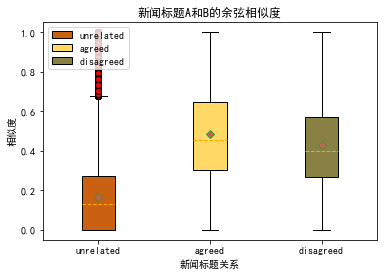

In [8]:
import matplotlib.pyplot as plt 
# 正确显示中文和负号 
plt.rcParams["font.sans-serif"] = ["SimHei"] 
plt.rcParams["axes.unicode_minus"] = False 
 
#三个箱型图的颜色 RGB （均为0~1的数据） 
colors = [(202/255.,96/255.,17/255.), (255/255.,217/255.,102/255.), (137/255.,128/255.,68/255.)] 
# 画图，plt.boxplot()可以画四分位箱图 
bplot = plt.boxplot(data, labels=Levels,showmeans=True,patch_artist=True,\
            boxprops = {'color':'black','facecolor':'#9999ff'},flierprops = {'marker':'o','markerfacecolor':'red','color':'black'},\
            meanprops = {'marker':'D','markerfacecolor':'indianred'},medianprops = {'linestyle':'--','color':'orange'}) 
 
#将三个箱分别上色 
for patch, color in zip(bplot['boxes'], colors): 
    patch.set_facecolor(color) 
        
# 添加描述信息 
plt.xlabel('新闻标题关系') 
plt.ylabel('相似度') 
plt.title('新闻标题A和B的余弦相似度') 
  
# 添加图例 
plt.legend(bplot['boxes'],Levels,loc='upper left')  # 要在绘制图像那一步添加标签 
  
# 显示图形 
plt.savefig(fname="imgs/pic-4pos.png", dpi=300)  
plt.show() 

我们明显看出'unrelated'关系的新闻标题A和B之间的余弦相似度分布在较低的取值区间。 
更精确的，再来看看以下百分位数分布点位[1,5,25,50,75,95,99]的余弦相似度取值。 

In [12]:
for i in range(len(data)): 
    print(Levels[i],np.percentile(data[i], [1,5,25,50,75,95,99], axis=0)) 

unrelated [0.         0.         0.         0.12928143 0.27184187 0.49754464
 0.68701292]
agreed [0.06130946 0.14686544 0.30364198 0.4526878  0.64951001 0.93696967
 1.        ]
disagreed [0.         0.0951492  0.26737468 0.40195025 0.56909786 0.88305113
 0.97880696]


### 一个升级版的猜测算法 
 
我们看到，大约95%的'unrelated'的余弦相似度小于0.5…… 
而余弦相似度数值在0.5以上时，'agreed'和'disagreed'区分度似乎并不明显。我们还可以沿用之前的策略，由于'agreed'的比例远大于'disagreed'，全部瞎猜成'agreed'命中的概率会比较高。 

这样，我们有了一个升级版的猜法：**新闻标题A和B余弦相似度小于0.5的判为'unrelated'，余弦相似度大于0.5的判为'agreed'。**  

我们来计算一下准确率。 

In [14]:
train_currect = train[(train['label'] == 'unrelated') & (train['cosin_measure'] < 0.50) \
                      | (train['label'] == 'agreed') & (train['cosin_measure'] >= 0.50)] 
accuracy = len(train_currect) / len(train) 
print('accuracy: {:.1%}'.format(accuracy)) 

accuracy: 77.4%


<font color="#dd0000">77.4%</font>！这是它在训练集上的准确率，与基线模型的<font color="#dd0000">68%</font>相比，已经有了近10个点的提升！ 

---
好了，今天就到这儿。 
